In [2]:
import warnings

warnings.simplefilter("ignore")

# Molecular Dynamics

In this tutorial we will cover how to use trained models to drive MD simulations.
For this purpose, apax offers two options: ASE and JaxMD. Keep in mind that JaxMD can be GPU/TPU accelerated and is therefore much faster.
Both will be covered below.

## Basic Model Training

First we need to train a model.
If you have the parameters from tutorial 01, you can point the paths to those models and skip the current section to the [ASE MD](##-The-ASE-calculator) or the [JaxMD](##-JaxMD) section.

In [3]:
!apax template train --full  # generating the config file in the cwd

Traceback (most recent call last):
  File "/home/tobiasdijkhuis/miniconda3/bin/apax", line 3, in <module>
    from apax.cli.apax_app import app
  File "/home/tobiasdijkhuis/PhD/apax_fork/apax/__init__.py", line 12, in <module>
    setup_ase()
  File "/home/tobiasdijkhuis/PhD/apax_fork/apax/utils/helpers.py", line 27, in setup_ase
    from ase.calculators.calculator import all_properties
  File "/home/tobiasdijkhuis/miniconda3/lib/python3.12/site-packages/ase/calculators/calculator.py", line 18, in <module>
    from ase.config import cfg as _cfg
  File "/home/tobiasdijkhuis/miniconda3/lib/python3.12/site-packages/ase/config.py", line 3, in <module>
    import configparser
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._boot

In [1]:
from pathlib import Path

import yaml

from apax.utils.datasets import download_etoh_ccsdt, mod_md_datasets
from apax.utils.helpers import mod_config

# Download and modify the dataset
data_path = Path("project")
experiment = "etoh_md"


train_file_path, test_file_path = download_etoh_ccsdt(data_path)
train_file_path = mod_md_datasets(train_file_path)
test_file_path = mod_md_datasets(test_file_path)


# Modify the config file (can be done manually)
config_path = Path("config_full.yaml")

config_updates = {
    "n_epochs": 100,
    "data": {
        "n_train": 990,
        "n_valid": 10,
        "valid_batch_size": 10,
        "experiment": experiment,
        "directory": "project/models",
        "data_path": str(train_file_path),
        "test_data_path": str(test_file_path),
        "energy_unit": "kcal/mol",
        "pos_unit": "Ang",
    },
}
config_dict = mod_config(config_path, config_updates)
del config_dict['transfer_learning']

with open("config_full.yaml", "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)

# Train model
# run(config_dict)

/home/tobiasdijkhuis/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyError: 'transfer_learning'

## The ASE calculator

If you require some ASE features during your simulation, we provide an alternative to the JaxMD interface.

Please refer to the [ASE documentation](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html)  to see how to use ASE calculators.

An ASE calculator of a trained model can be instantiated as follows. Subsequend a ASE-MD is performed and OH-bondlength distribution is analysed.

In [ ]:
from ase import units
from ase.io import read
from ase.io.trajectory import Trajectory
from ase.md.langevin import Langevin

from apax.md import ASECalculator

# read starting structure and define modelpath
atoms = read(train_file_path, index=0)
model_dir = data_path / f"models/{experiment}"


# initialize the apax ase calculator and assign it to the starting structure
calc = ASECalculator(model_dir=model_dir)
atoms.calc = calc

# perform MD simulation
dyn = Langevin(
    atoms=atoms,
    timestep=0.5 * units.fs,
    temperature_K=300,
    friction=0.001 / units.fs,
)

traj = Trajectory("example.traj", "w", atoms)
dyn.attach(traj.write, interval=1)
dyn.run(10000)
traj.close()

<a id='bondlength'></a>

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_bondlength_distribution(traj, indices: list, bins: int = 25):
    oh_dist = []
    for atoms in traj:
        oh_dist.append(atoms.get_distances(indices[0], indices[1]))

    fig, axs = plt.subplots()
    axs.hist(np.array(oh_dist), bins=25)
    fig.show()

/tmp/ipykernel_131697/524601467.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


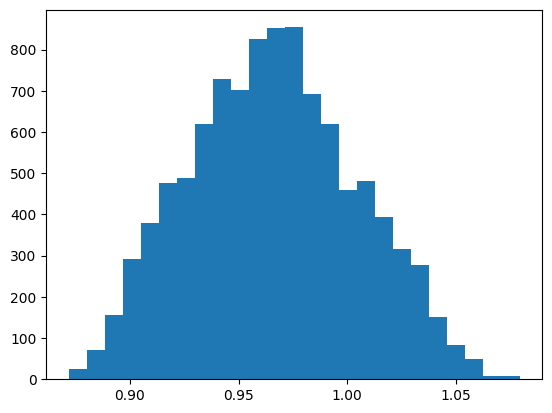

In [ ]:
# plot OH bondlength distribution of the MLMD simulation
traj = Trajectory("example.traj")
plot_bondlength_distribution(traj, indices=[2, -1])

## JaxMD

While the ASE interface is convenient and flexible, it is not meant for high performance applications.
For these purposes, apax comes with an interface to [JaxMD](https://jax-md.readthedocs.io/en/main/#).
JaxMD is a high performance molecular dynamics engine built on top of [Jax](https://jax.readthedocs.io/en/latest/index.html).
The CLI provides easy access to standard NVT and NPT simulations.
More complex simulation loops are relatively easy to build yourself in JaxMD (see their colab notebooks for examples). 
Trained apax models can of course be used as `energy_fn` in such custom simulations.
If you have a suggestion for adding some MD feature or thermostat to the core of `apax`, feel free to open up an issue on [Github](https://github.com/apax-hub/apax).


### Configuration
We can once again use the template command to give ourselves a quickstart.


In [ ]:
!apax template md


Open the config and specify the starting structure and simulation parameters.
If you specify the data set file itself, the first structure of the data set is going to be used as the initial structure.
Your `md_config.yaml` should look similar to this:

```yaml
ensemble:
    temperature: 300 # K
    
duration: 20_000 # fs
initial_structure: project/benzene_mod.xyz
```
Full configuration file with descriptiond of the parameter can be found [here](https://github.com/apax-hub/apax/blob/main/apax/cli/templates/md_config_minimal.yaml).

In [10]:
import yaml

from apax.utils.helpers import mod_config

md_config_path = Path("md_config.yaml")

config_updates = {
    "initial_structure": str(
        train_file_path
    ),  # if the model from example 01 is used change this
    "duration": 5000,  # fs
    "ensemble": {
        "temperature_schedule": {
            "T0": 300,
            "name": "constant",
        },
    },
}
config_dict = mod_config(md_config_path, config_updates)

with open(md_config_path, "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)


As with training configurations, we can use the `validate` command to ensure our input is valid before we submit the calculation.


In [11]:
!apax validate md md_config.yaml

Success!
md_config.yaml is a valid MD config.


## Running the simulation

The simulation can be started by running where `config.yaml` is the configuration file that was used to train the model.

In [12]:
!apax md config_full.yaml md_config.yaml

INFO | 21:26:06 | reading structure
INFO:2026-02-11 21:26:06,775:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO | 21:26:06 | Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO | 21:26:06 | initializing model
INFO | 21:26:07 | loading checkpoint from /home/tobiasdijkhuis/PhD/apax_fork/examples/project/models/etoh_md/best
WARNING | 21:26:07 | `StandardCheckpointHandler` expects a target tree to be provided for restore. Not doing so is generally UNSAFE unless you know the present topology to be the same one as the checkpoint was saved under.
INFO | 21:26:08 | Building Standard model
INFO | 21:26:08 | initializing simulation
INFO | 21:26:18 | running simulation for 5.0 ps
Simulation: 100%|█████████████████████████████████| 10000/10000 [00:31<00:00, 312.62it/s, T=269.7 K]
INF

During the simulation, a progress bar tracks the instantaneous temperature at each outer step.
The simulation is followed by a small oh bondlength distribution analyses of the trajectory defined [here](#bondlength).

/tmp/ipykernel_177348/524601467.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


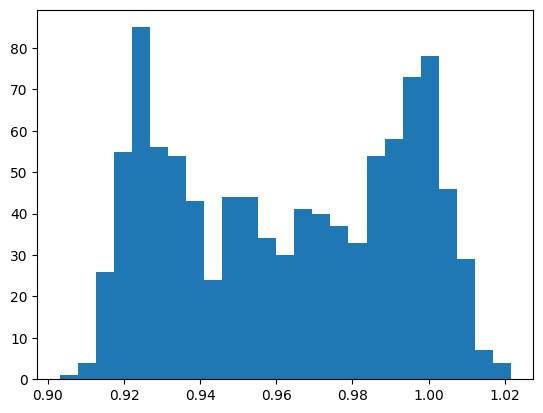

In [13]:
import znh5md

atoms = znh5md.IO("md/md.h5")[:]
plot_bondlength_distribution(atoms, indices=[2, -1])

To remove all the created files and clean up yor working directory run

In [ ]:
!rm -rf project md config_full.yaml example.traj md_config.yaml

# OpenMM

While JaxMD is very fast, it is less mature than other dynamics codes, such as OpenMM. Apax also comes with an interface to OpenMM, which can be installed as 

    $ pip install apax[openmm]

This requires at least OpenMM 8.5.0.

In [6]:
from sys import stdout

from ase.io import read

# read starting structure and define modelpath
atoms = read(train_file_path, index=0)
model_dir = data_path / f"models/{experiment}"

from openmm.app import StateDataReporter
from openmm.openmm import CMMotionRemover, LangevinIntegrator, PythonForce
from openmm.unit import femtosecond, kelvin, picosecond

from apax.md.openmm_interface import OpenMMInterface, create_simulation, create_system
from apax.utils.openmm_reporters import XYZReporter

interface = OpenMMInterface(model_dir)
force = PythonForce(interface.get_python_force_fn(atoms))
force.setUsesPeriodicBoundaryConditions(False)

integrator = LangevinIntegrator(
    300 * kelvin, 1/picosecond, 0.5 * femtosecond
)
system = create_system(atoms)
system.addForce(force)
system.addForce(CMMotionRemover(1))

simulation = create_simulation(atoms, system, integrator)
simulation.context.setVelocitiesToTemperature(300 * kelvin, 1)

xyz_path = "openmm_trajectory.xyz"
md_steps = 10000

simulation.reporters.append(
    StateDataReporter(
        stdout,
        2000,
        time=True,
        progress=True, 
        potentialEnergy=True, 
        kineticEnergy=True, 
        temperature=True, 
        totalSteps=md_steps,
    )
)
simulation.reporters.append(
    XYZReporter(
        xyz_path,
        10,
        atoms.symbols,
        enforcePeriodicBox=False,
        includeForces=False,
        includeVelocities=False,
        flushEvery = 10,
    )
)

simulation.step(md_steps)



#"Progress (%)","Time (ps)","Potential Energy (kJ/mole)","Kinetic Energy (kJ/mole)","Temperature (K)"
20.0%,0.9999999999999453,-406213.7805919794,34.11113725373834,341.8855675577314
40.0%,1.9999999999998352,-406230.93096930924,31.571678658683112,316.4333454109993
60.0%,3.000000000000169,-406234.04798863,28.556831350898033,286.21644659420485
80.0%,4.000000000000503,-406229.7862321988,42.515449450014415,426.1194359211005
100.0%,4.9999999999999485,-406237.1326619934,37.50137141376137,375.864854772087


/tmp/ipykernel_194307/524601467.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


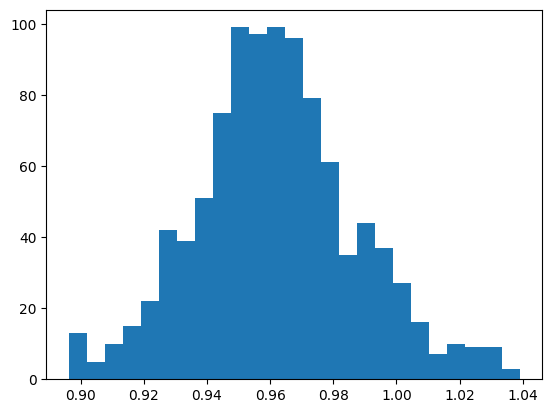

In [7]:
traj = read(xyz_path, index=":")
plot_bondlength_distribution(traj, indices=[2, -1])